# Goal: determine accuracy of p2rank's predicted binding residues

## Proposal

1. Compute centroid of ground truth binding residues of wild-type template 1tqn.

2. plot ground truth and predicted centroids onto the number line

3. perform hypothesis testing

In [19]:
def get_vectors_of_residue_r_group(residue_ids, mutant_code, pdb_folder, chain):
    """
        residue_ids (list of int): for eg: [1, 2, 3, 4...], it must be sorted
        mutant_code (str): for eg: CYP3A4.11
        pdb_folder (str): for eg: 'pdb_f/scwrl_out'
        chain (str): for eg: 'A' which represents chain A.
        
        return map, for eg 'A_50': [vector_of_atom1_res_50, vector_of_atom2_res50] etc

    """
    #get correct pdb
    import os
    pdb_files = os.listdir(pdb_folder)
    mutant_pdb = list(filter(lambda file: mutant_code in file, pdb_files))[0]
    
    import re
    pattern = re.compile('^ATOM')
    back_bone_atoms = set(['N', 'CA', 'O', 'C'])
    
    result = {}
    
    with open(pdb_folder + '/' + mutant_pdb, 'r') as mutant_pdb:
        lines = mutant_pdb.readlines()
        
        for res_id in residue_ids:
            
            res_num = str(res_id)
            result[res_id] = []
            
            for line in lines:
                if pattern.match(line):
                    tokens = re.split("\s{1,}", line)
                    
                    from_pdb_chain_type = tokens[4]
                    from_pdb_res_number = tokens[5]
                    from_pdb_atom = tokens[2]
                    
                    if chain == from_pdb_chain_type and res_num == from_pdb_res_number and not from_pdb_atom in back_bone_atoms:
                        #print(from_pdb_atom)
                        x_coord = float(tokens[6])
                        y_coord = float(tokens[7])
                        z_coord = float(tokens[8])
                        
                        result[res_id].append([x_coord, y_coord, z_coord])
                        
                         
    return result

def compute_centroid(vectors):
    """
        vectors: a list of lists for eg: [[1,2,3], [4,5,6], [7,8,9]]
        note that each inner list is a list of float values
        and a inner list is a row vector in R^3 for eg: given, [1,2,3], 1 is the x-coordinate, 2 is the y-coordinate and 3 is the z-coordinate
        
        returns a  centroid as a row_vector in R^3
    """
    import numpy as np
    #we are going to represent vectors as a 2d matrix, with each row being a row vector in R^3
    two_d_matrix = np.array(vectors)
    n = len(vectors)
    centroid = 1/n * np.sum(two_d_matrix, axis=0)
    return centroid

## Get coordinates of side chain atoms for each ground truth binding residues in 1tqn


In [20]:
import re

#get centroid of 1tqn binding site residues

binding_residues_1tqn = [105, 119, 126, 130, 137, 305, 306, 313, 370, 375, 434, 435, 436, 437, 440, 442, 443, 452]

residue_vectors_map = get_vectors_of_residue_r_group(binding_residues_1tqn, '1tqn', 'pdb_f', 'A')
print(len(residue_vectors_map))

18


## Get centroid coordinates of side chains for each ground truth binding residues in 1tqn

In [21]:
residue_id_centroid_map = {}

for residue_id in residue_vectors_map:
    list_of_vectors = residue_vectors_map[residue_id]
    #print(list_of_vectors)
    if len(list_of_vectors) == 0:
        print(residue_id)
        continue
    residue_id_centroid_map[residue_id] = compute_centroid(list_of_vectors)
    
residue_id_centroid_map

306
436


{105: array([-16.58214286, -13.95042857,  -9.53157143]),
 119: array([-18.5705, -17.663 ,  -5.529 ]),
 126: array([-10.3595, -13.4384,  -4.2056]),
 130: array([ -8.587     , -18.10342857,  -5.66657143]),
 137: array([-10.777     , -26.47828571,  -4.37171429]),
 305: array([-18.976, -23.889,  -7.776]),
 313: array([-19.07633333, -29.06066667, -19.046     ]),
 370: array([-18.861, -18.743, -16.885]),
 375: array([-12.80571429, -10.75057143, -12.62742857]),
 434: array([-12.805     , -22.41433333, -21.13366667]),
 435: array([-12.523     , -24.68814286, -16.33757143]),
 437: array([ -7.0395, -16.1975, -17.1685]),
 440: array([-13.03357143, -13.19385714,  -6.895     ]),
 442: array([-13.1815, -22.9075, -12.0125]),
 443: array([-10.657  , -22.57975,  -5.85875]),
 452: array([-16.1915 , -32.102  , -16.83525])}

## Compute centre of centroids for 1tqn

In [22]:
centroids_1tqn = []

for residue_id in residue_id_centroid_map:
    centroids_1tqn.append(residue_id_centroid_map[residue_id])

centre_of_centroids_1tqn = compute_centroid(centroids_1tqn)
print(centre_of_centroids_1tqn)

[-13.75164137 -20.38499152 -11.36750774]


## Computre centre of centroids for all mutants

In [23]:
import os

def get_residue_ids_from_p2rank_predictions(pred_csv):
    """
        pred_csv (str): abs file path to a prediction.csv generated by p2rank
        return a sorted list of residues_id, for eg ['A_1', 'A_2'...]
    """
    import pandas as pd
    
    pred_result_df = pd.read_csv(pred_csv)
    #going to get the top result, a.k.a first row
    
    return sorted(pred_result_df.iloc[0, 9].strip().split(' '), key=lambda token: int(token.split('_')[-1]))

def get_mutant_code_from_pred_csv(pred_csv):
    
    """
        pred_csv (str): for this function, don't need to get abs file path.
        for eg: CYP3A4.3.pdbqt_predictions.csv
        
        return just the mutant code, for eg: CYP3A4.3
    """
    return pred_csv.split('_')[0].replace('.pdbqt', '')

def get_vectors_of_residue_r_group_pdbqt(residue_ids, mutant_code, pdb_folder):
    """
        residue_ids (list of str): for eg: ['A_50','A_57','A_76','A_78'], it must be sorted
        mutant_code (str): for eg: CYP3A4.11
        pdb_folder (str): for eg: 'pdb_f/scwrl_out'
        
        return map for eg 'A_50': [vector_of_atom1_res_50, vector_of_atom2_res50] etc

    """
    #get correct pdb
    pdb_files = os.listdir(pdb_folder)
    mutant_pdb = list(filter(lambda file: mutant_code in file, pdb_files))[0]
    
    import re
    pattern = re.compile('^ATOM')
    back_bone_atoms = set(['N', 'CA', 'O', 'C'])
    
    result = {}
    
    with open(pdb_folder + '/' + mutant_pdb, 'r') as mutant_pdb:
        lines = mutant_pdb.readlines()
        
        for res_id in residue_ids:
            chain, res_num = res_id.split('_')
            result[res_id] = []
            
            for line in lines:
                if pattern.match(line):
                    tokens = re.split("\s{1,}", line)
                    
                    from_pdb_chain_type = tokens[4]
                    from_pdb_res_number = tokens[5]
                    from_pdb_atom = tokens[2]
                    
                    if chain == from_pdb_chain_type and res_num == from_pdb_res_number and not from_pdb_atom in back_bone_atoms:
                        #print(from_pdb_atom)
                        x_coord = float(tokens[6])
                        y_coord = float(tokens[7])
                        z_coord = float(tokens[8])
                        
                        result[res_id].append([x_coord, y_coord, z_coord])
                        
                         
    return result

def compute_centroid(vectors):
    """
        vectors: a list of lists for eg: [[1,2,3], [4,5,6], [7,8,9]]
        note that each inner list is a list of float values
        and a inner list is a row vector in R^3 for eg: given, [1,2,3], 1 is the x-coordinate, 2 is the y-coordinate and 3 is the z-coordinate
        
        returns a  centroid as a row_vector in R^3
    """
    import numpy as np
    #we are going to represent vectors as a 2d matrix, with each row being a row vector in R^3
    two_d_matrix = np.array(vectors)
    n = len(vectors)
    centroid = 1/n * np.sum(two_d_matrix, axis=0)
    return centroid

In [24]:
mt_code_centre_of_centroids = {}
pred_files = list(filter(lambda file: 'predictions' in file, os.listdir('predicted_binding_sites')))

for mutant_pred_file in pred_files:
    
    full_path_to_pred_file = os.path.join('predicted_binding_sites', mutant_pred_file)
    print(full_path_to_pred_file)
    residue_ids = get_residue_ids_from_p2rank_predictions(full_path_to_pred_file)
    mutant_code = get_mutant_code_from_pred_csv(mutant_pred_file)
    
    residue_vectors_map = get_vectors_of_residue_r_group_pdbqt(residue_ids, mutant_code, 'pdb_f/scwrl_out')
    
    residue_id_centroid_map = {}

    for residue_id in residue_vectors_map:
        list_of_vectors = residue_vectors_map[residue_id]
        
        if len(list_of_vectors) == 0:
            print(residue_id)
            continue
            
        residue_id_centroid_map[residue_id] = compute_centroid(list_of_vectors)
    
    centroids = []

    for residue_id in residue_id_centroid_map:
        centroids.append(residue_id_centroid_map[residue_id])

    centre_of_centroids = compute_centroid(centroids)
    mt_code_centre_of_centroids[mutant_code] = centre_of_centroids

predicted_binding_sites/CYP3A4-I369V.pdbqt_predictions.csv
A_306
A_436
A_444
predicted_binding_sites/CYP3A4-M371I.pdbqt_predictions.csv
A_306
A_436
A_444
A_481
predicted_binding_sites/CYP3A4-S119T.pdbqt_predictions.csv
A_306
A_436
A_444
predicted_binding_sites/CYP3A4-E374Q.pdbqt_predictions.csv
A_306
A_436
A_444
predicted_binding_sites/CYP3A4-L373H.pdbqt_predictions.csv
A_306
A_436
A_444
predicted_binding_sites/CYP3A4-A305S.pdbqt_predictions.csv
A_306
A_436
A_444
predicted_binding_sites/CYP3A4-S119V.pdbqt_predictions.csv
A_306
A_436
A_444
predicted_binding_sites/CYP3A4-P107S.pdbqt_predictions.csv
A_306
A_436
A_444
predicted_binding_sites/CYP3A4.12.pdbqt_predictions.csv
A_306
A_436
A_444
predicted_binding_sites/CYP3A4-R212A.pdbqt_predictions.csv
A_306
A_436
A_444
predicted_binding_sites/CYP3A4-I301A.pdbqt_predictions.csv
A_306
A_436
A_444
predicted_binding_sites/CYP3A4-A370V.pdbqt_predictions.csv
A_306
A_436
A_444
predicted_binding_sites/CYP3A4-I301F.pdbqt_predictions.csv
A_306
A_436
A_

In [26]:
mt_code_centre_of_centroids

{'CYP3A4-I369V': array([-20.82358864, -18.61979434, -11.11221198]),
 'CYP3A4-M371I': array([-20.80930585, -18.61751838, -11.11319832]),
 'CYP3A4-S119T': array([-20.80897662, -18.62285991, -11.11763821]),
 'CYP3A4-E374Q': array([-20.82142471, -18.62211183, -11.10397865]),
 'CYP3A4-L373H': array([-20.82332635, -18.63452931, -11.11121062]),
 'CYP3A4-A305S': array([-20.81588372, -18.63051019, -11.09741144]),
 'CYP3A4-S119V': array([-20.81878536, -18.61830254, -11.11379122]),
 'CYP3A4-P107S': array([-20.8279329 , -18.62900746, -11.08537319]),
 'CYP3A4.12': array([-20.82407225, -18.63845281, -11.11133708]),
 'CYP3A4-R212A': array([-21.71960277, -19.75794863, -11.87798204]),
 'CYP3A4-I301A': array([-20.80820415, -18.62420357, -10.92614674]),
 'CYP3A4-A370V': array([-20.81674165, -18.61351292, -11.10332947]),
 'CYP3A4-I301F': array([-20.81195457, -18.6098603 , -11.12676272]),
 'CYP3A4-I301W': array([-20.82483068, -18.61188372, -11.13862432]),
 'CYP3A4-C98A': array([-20.82124438, -18.62227248, 

In [27]:
centre_of_centroids_1tqn

array([-13.75164137, -20.38499152, -11.36750774])

In [28]:
centre_of_centroids_1tqn[0]

-13.751641369047618

## Data visualisation

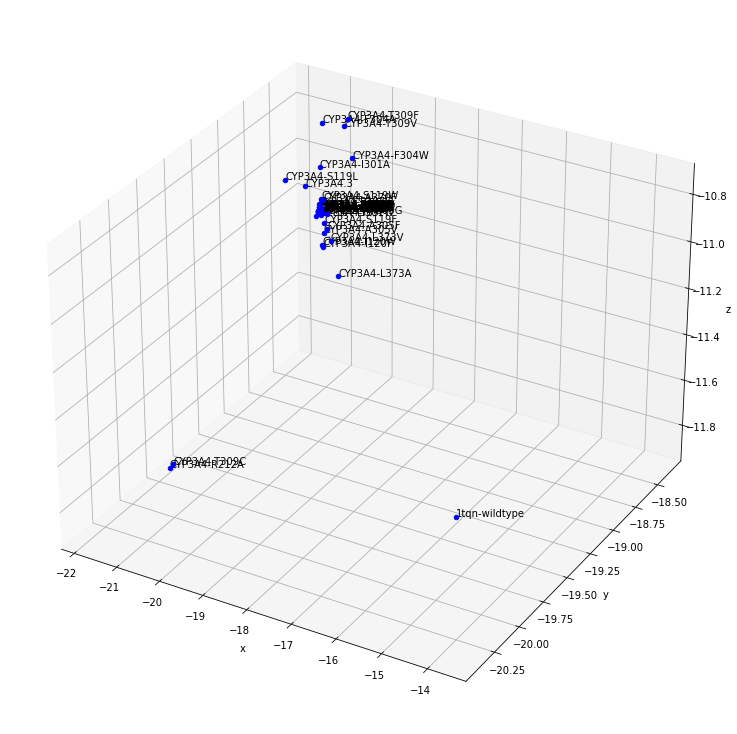

In [43]:
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D

from pylab import figure

fig = figure(figsize=(10,10))

ax = Axes3D(fig)

ax.scatter(-13.75164137, -20.38499152, -11.36750774, color='b')
ax.text(-13.75164137, -20.38499152, -11.36750774,  '%s' % ('1tqn-wildtype'), size=10, zorder=1, color='k')


for mt_code in mt_code_centre_of_centroids:
    x, y, z = mt_code_centre_of_centroids[mt_code]
    ax.scatter(x, y, z, color='b')
    ax.text(x, y, z, '%s' % (mt_code), size=10, zorder=1, color='k')
    
    

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show()


In [3]:
path = 'docking_result/'
new_content = ''

with open(path + 'CYP3A4.3_15634941_docking_result.pdbqt', 'r') as file:
    lines = file.readlines()
    
    for line in lines:
        if 'MODEL 2' in line:
            break
        new_content = new_content + line

            
with open(path + 'CYP3A4.3_15634941_docking_result.pdbqt', 'w') as file:
    file.write(new_content)

In [1]:
import pandas as pd

bind_csv = 'predicted_binding_sites/CYP3A4.3.pdbqt_predictions.csv'
df = pd.read_csv(bind_csv)
res_id_string = df.iloc[0,9].strip().split(' ')

res_chain = []
for res_id in res_id_string:
    res_chain.append(res_id.split('_')[-1])

res_chain = sorted(res_chain)
print('+'.join(res_chain))

105+106+107+108+118+119+120+126+137+180+183+184+188+212+213+215+216+220+221+223+224+227+230+241+271+299+301+302+303+304+305+306+309+310+312+313+364+369+370+371+372+373+374+375+434+435+436+440+441+442+443+444+447+448+451+482+483+50+57+76+78+79+94


In [11]:
sorted(res_id_string)

['A_105',
 'A_106',
 'A_107',
 'A_108',
 'A_118',
 'A_119',
 'A_120',
 'A_126',
 'A_137',
 'A_180',
 'A_183',
 'A_184',
 'A_188',
 'A_212',
 'A_213',
 'A_215',
 'A_216',
 'A_220',
 'A_221',
 'A_223',
 'A_224',
 'A_227',
 'A_230',
 'A_241',
 'A_271',
 'A_299',
 'A_301',
 'A_302',
 'A_303',
 'A_304',
 'A_305',
 'A_306',
 'A_309',
 'A_310',
 'A_312',
 'A_313',
 'A_364',
 'A_369',
 'A_370',
 'A_371',
 'A_372',
 'A_373',
 'A_374',
 'A_375',
 'A_434',
 'A_435',
 'A_436',
 'A_440',
 'A_441',
 'A_442',
 'A_443',
 'A_444',
 'A_447',
 'A_448',
 'A_451',
 'A_482',
 'A_483',
 'A_50',
 'A_57',
 'A_76',
 'A_78',
 'A_79',
 'A_94']

In [54]:
df = pd.read_csv('test_db/single_near_mutant_CYP3A4_db.csv')


#
df = df[df['act'].notna()]
#df.to_csv('test_db/single_near_mutant_CYP3A4_db.csv', columns=cols)
#df = df.loc[:,['mt_code', 'rel_act', 'act', 'cid']]
#df

In [55]:
#cols = df.columns[1:]
df.iloc[:, 13]

0      15634941
1      20812728
2      10666307
3      10666307
4      10666307
         ...   
224    11470997
225    11470997
226    10773032
227    11714865
228    11714865
Name: pubmed_id, Length: 229, dtype: int64

In [37]:
cids = df.iloc[:, 13].unique()
count = 0
for cid in cids:
    if cid == 'pmol/min/pmol':
        print(count)
        break
    str_cid = str(int(cid))
    count += 1

In [3]:
df = pd.read_csv('test_db/single_near_mutant_CYP3A4_db.csv')
df.iloc[:, 14]
print(df.columns)

Index(['Unnamed: 0', 'mt_code', 'wt_code', 'mt_seq', 'rxn_id', 'substrate',
       'product', 'type', 'EC', 'co_protein', 'rel_act', 'act', 'act_unit',
       'pubmed_id', 'cid', 'cas_num', 'canonical_smiles', 'isomeric_smiles',
       'iupac_name', 'wt_seq', 'organism', 'nearest_pdb'],
      dtype='object')


In [34]:
unique = set()
df.loc[:, ['mt_code', 'cid']]

,mt_code,cid
0,CYP3A4.3,4485
1,CYP3A4-S119A,6013
2,CYP3A4-S119A,6013
3,CYP3A4-S119A,6013
4,CYP3A4-S119L,6013
...,...,...
224,CYP3A4.11,848780
225,CYP3A4.12,848780
226,CYP3A4-F304W,11790
227,CYP3A4.3,2730


In [35]:
for index, row in df.loc[:, ['mt_code', 'cid']].iterrows():
    unique.add((row[0], row[1]))

In [51]:
len(unique)

107

In [21]:
import os 
len(os.listdir('docking_result'))

82

In [22]:
unique

{('CYP3A4-A305F', 3035604),
 ('CYP3A4-A305G', 4993),
 ('CYP3A4-A305G', 5994),
 ('CYP3A4-A305G', 6013),
 ('CYP3A4-A305G', 566440),
 ('CYP3A4-A305S', 3016),
 ('CYP3A4-A305V', 4993),
 ('CYP3A4-A305V', 5994),
 ('CYP3A4-A305V', 6013),
 ('CYP3A4-A305V', 566440),
 ('CYP3A4-A370C', 4192),
 ('CYP3A4-A370F', 3016),
 ('CYP3A4-A370F', 55245),
 ('CYP3A4-A370F', 3035604),
 ('CYP3A4-A370V', 4993),
 ('CYP3A4-A370V', 566440),
 ('CYP3A4-C98A', 4192),
 ('CYP3A4-C98F', 4192),
 ('CYP3A4-C98S', 4192),
 ('CYP3A4-C98W', 4192),
 ('CYP3A4-F304A', 4192),
 ('CYP3A4-F304A', 4993),
 ('CYP3A4-F304A', 5994),
 ('CYP3A4-F304A', 6013),
 ('CYP3A4-F304A', 566440),
 ('CYP3A4-F304W', 4192),
 ('CYP3A4-F304W', 6013),
 ('CYP3A4-F304W', 11790),
 ('CYP3A4-F304W', 566440),
 ('CYP3A4-I120F', 5994),
 ('CYP3A4-I120L', 6013),
 ('CYP3A4-I120L', 14403),
 ('CYP3A4-I120W', 4192),
 ('CYP3A4-I120W', 5994),
 ('CYP3A4-I301A', 3016),
 ('CYP3A4-I301A', 4993),
 ('CYP3A4-I301A', 5994),
 ('CYP3A4-I301A', 6013),
 ('CYP3A4-I301A', 566440),
 ('CYP3A

In [26]:
def get_ligand_sdfs(db_path):
    db_df = pd.read_csv(db_path)
    CID_COL_INDEX = 14
    cids = db_df.iloc[:, CID_COL_INDEX].unique()
    return cids



In [27]:
get_ligand_sdfs('/home/howc/PycharmProjects/pythonProject2/src/test_db/single_near_mutant_CYP3A4_db.csv')

array([   4485,    6013,    5994,    4993,    4192,  566440,   14403,
          3016,   55245, 3035604,  848780,   11790,    2730])

In [33]:
len(os.listdir('pdb_f/scwrl_out'))

48

In [32]:
len(df.iloc[:,1].unique())

48

In [48]:
bind_csv = 'predicted_binding_sites/CYP3A4.3.pdbqt_predictions.csv'
df = pd.read_csv(bind_csv)
res_id_string = df.iloc[0,9].strip().split(' ')

res_chain = []
for res_id in res_id_string:
    res_chain.append(res_id.split('_')[-1])

res_chain = sorted(res_chain)

import csv

with open(bind_csv, 'r') as csvfile:
    csv_f = csv.reader(csvfile, delimiter=',')
    count = 0
    res_ids = None
    for row in csv_f:
        if count == 0:
            count += 1
            continue
        if count == 1:
            res_ids = row[9].strip().split(' ')
            break
    res_ids_processed = []
    
    for res_id in res_ids:
        res_ids_processed.append(res_id.split('_')[-1])
    
    
    print('+'.join(res_ids_processed))


105+106+107+108+118+119+120+126+137+180+183+184+188+212+213+215+216+220+221+223+224+227+230+241+271+299+301+302+303+304+305+306+309+310+312+313+364+369+370+371+372+373+374+375+434+435+436+440+441+442+443+444+447+448+451+482+483+50+57+76+78+79+94


In [49]:
len(os.listdir('docking_out'))

107

In [50]:
len(os.listdir('docking_result'))

107

In [60]:
import re

pattern = re.compile('^HETATM')

for docking_result in os.listdir('docking_result'):
    
    ligand_pose_info = ''
    
    with open('docking_result/' + docking_result, 'r') as file:
        lines = file.readlines()
    
    for line in lines:
        if pattern.match(line):
            ligand_pose_info = ligand_pose_info + line
    
    pdb = docking_result.split('_')[0]
    ligand = docking_result.split('_')[1]
    
    scwrl_file = list(filter(lambda file: pdb in file, os.listdir('pdb_f/scwrl_out')))[0]
    
    pdb_info = ''
    
    with open('pdb_f/scwrl_out/' + scwrl_file, 'r') as file:
        for line in file.readlines():
            pdb_info = pdb_info + line
    #print(pdb_info)
    #print(ligand_pose_info)
    with open(f'protein_ligand_pdb/{pdb}_{ligand}_complex.pdb', 'a+') as file:
        file.write(pdb_info + '\n')
        file.write(ligand_pose_info)

In [61]:
len(os.listdir('protein_ligand_pdb'))

107